In [1]:
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append('/home/yang_liu/python_workspace/gaussian-splatting-lightning')

import json
import pickle
import torch
import torch_scatter
import alphashape
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from plyfile import PlyData, PlyElement

## 1. Analyze Checkpoints

In [2]:
file_dir = '../data/GauU_Scene/LFLS/LFLS_ds_35.ply'
plydata = PlyData.read(file_dir)
data = plydata.elements[0].data
data_pd = pd.DataFrame(data)
data_np = np.zeros(data_pd.shape, dtype=np.float32)
property_names = data[0].dtype.names
for i, name in enumerate(property_names):
    data_np[:, i] = data_pd[name]

x_min, x_max = np.min(data_np[:, 0]), np.max(data_np[:, 0])
y_min, y_max = np.min(data_np[:, 1]), np.max(data_np[:, 1])

In [3]:
transform_dir = '../data/GauU_Scene/Downsampled/LFLS/transform.txt'
with open(transform_dir, 'r') as f:
    transform = np.loadtxt(f)
xyz_homo = np.concatenate([data_np[:, :3], np.ones_like(data_np[:, :1])], axis=-1)
data_np_pcd = (xyz_homo @ np.linalg.inv(transform).T)[:, :3]

In [4]:
transform_traj_dir = '../data/GauU_Scene/Downsampled/LFLS/transform_traj.txt'
with open(transform_traj_dir, 'r') as f:
    transform_traj = np.loadtxt(f)

In [6]:
from internal.utils.gaussian_model_loader import GaussianModelLoader
from internal.renderers.vanilla_trim_renderer import VanillaTrimRenderer
from internal.utils.sh_utils import SH2RGB
# load model and dataset
ckpt_path = '../outputs/citygs2d_lfls_lnorm8_wo_vast_sep_depth/checkpoints/epoch=32-step=30000.ckpt'
model, renderer = GaussianModelLoader.search_and_load(
    ckpt_path,
    sh_degree=3,
    device="cuda",
)
if isinstance(renderer, VanillaTrimRenderer):
    model._scaling = torch.cat((torch.ones_like(model._scaling[:, :1]) * 1e-8, model._scaling[:, [-2, -1]]), dim=1)

In [5]:
ckpt_path_coarse = '../outputs/citygs2d_lfls_coarse_lnorm8_wo_vast_sep_depth_init_5/checkpoints/epoch=32-step=30000.ckpt'
model_coarse, renderer = GaussianModelLoader.search_and_load(
    ckpt_path_coarse,
    sh_degree=3,
    device="cuda",
)
if isinstance(renderer, VanillaTrimRenderer):
    model_coarse._scaling = torch.cat((torch.ones_like(model_coarse._scaling[:, :1]) * 1e-8, model_coarse._scaling[:, [-2, -1]]), dim=1)

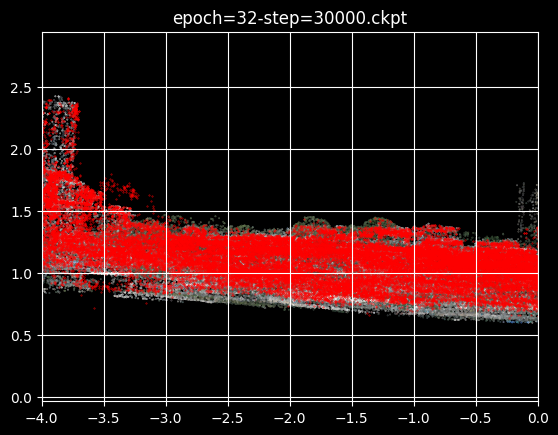

In [7]:
plt.figure()
xyz = model.get_xyz.cpu().numpy()
xyz_homo = np.concatenate([xyz[:, :3], np.ones_like(xyz[:, :1])], axis=-1)
xyz[:, :3] = ((xyz_homo @ np.linalg.inv(transform).T) @ transform_traj.T)[:, :3]
mask_range = (xyz[:, 0] >= x_min) & (xyz[:, 1] >= y_min) & (xyz[:, 0] <= x_max) & (xyz[:, 1] <= y_max)

# xyz_coarse = model_coarse.get_xyz.cpu().numpy()
# xyz_coarse_homo = np.concatenate([xyz_coarse[:, :3], np.ones_like(xyz_coarse[:, :1])], axis=-1)
# xyz_coarse[:, :3] = (xyz_coarse_homo @ np.linalg.inv(transform).T)[:, :3]
# mask_range_coarse = (xyz_coarse[:, 0] >= x_min) & (xyz_coarse[:, 1] >= y_min) & (xyz_coarse[:, 0] <= x_max) & (xyz_coarse[:, 1] <= y_max)

plt.scatter(data_np_pcd[::100, 0], data_np_pcd[::100, 2], s=0.1, c=data_np[::100, 3:6] / 255.0)
plt.scatter(xyz[mask_range][::100, 0], xyz[mask_range][::100, 2], s=0.1, c='r')
# plt.scatter(xyz_coarse[::100, 0], xyz_coarse[::100, 2], s=0.1, c='b')
plt.axis('equal')
plt.xlim(-4, 0)
# plt.ylim(-4, 0)
plt.title(ckpt_path.split('/')[-1])
plt.grid()
plt.show()

## 2. Point Cloud Filtering

In [7]:
def voxel_filtering(voxel_size, xy_range, gt_xyz, target_xyz):
    assert len(xy_range) == 4, "Unrecognized xy_range format"
    with torch.no_grad():
        voxel_dim = torch.tensor([int((xy_range[2] - xy_range[0]) / voxel_size[0]), int((xy_range[3] - xy_range[1]) / voxel_size[1])])
        gt_voxel_index = torch.div(gt_xyz[::100, :2] - xy_range[None, :2], voxel_size[None, :], rounding_mode='floor')
        gt_voxel_index_1d = gt_voxel_index[:, 1] * voxel_dim[0] + gt_voxel_index[:, 0]
        
        gt_new_index, gt_unq_inv, _ = torch.unique(gt_voxel_index_1d, return_inverse=True, return_counts=True, dim=0)
        gt_vox_z_max = torch_scatter.scatter_max(gt_xyz[::100, 2], gt_unq_inv, dim=0)[0]
        mapper = - torch.ones(gt_new_index.long().max()+1, dtype=torch.long)
        mapper[gt_new_index.long()] = torch.arange(gt_new_index.shape[0])

        target_voxel_index = torch.div(target_xyz[:, :2] - xy_range[None, :2], voxel_size[None, :], rounding_mode='floor')
        target_voxel_index_1d = target_voxel_index[:, 1] * voxel_dim[0] + target_voxel_index[:, 0]
        target_new_index, target_unq_inv, _ = torch.unique(target_voxel_index_1d, return_inverse=True, return_counts=True, dim=0)
        mask = torch.isin(target_new_index, gt_new_index)
        z_max = torch.ones_like(target_new_index, dtype=gt_vox_z_max.dtype) * gt_vox_z_max.max()
        z_max[mask] = gt_vox_z_max[mapper[target_new_index[mask].long()]]
        z_max = z_max[target_unq_inv]

        mask = target_xyz[:, -1] < z_max

    return mask

def voxel_filtering_no_gt(voxel_size, xy_range, target_xyz, require_unq_inv=False):
    assert len(xy_range) == 4, "Unrecognized xy_range format"
    with torch.no_grad():

        voxel_index = torch.div(torch.tensor(target_xyz[:, :2]).float() - xy_range[None, :2], voxel_size[None, :], rounding_mode='floor')
        voxel_coords = voxel_index * voxel_size[None, :] + xy_range[None, :2] + voxel_size[None, :] / 2

        new_coors, unq_inv, unq_cnt = torch.unique(voxel_coords, return_inverse=True, return_counts=True, dim=0)
        feat_mean = torch_scatter.scatter(target_xyz[:, 2], unq_inv, dim=0, reduce='mean')
        feat_std = torch_scatter.scatter_std(target_xyz[:, 2], unq_inv, dim=0)

    if require_unq_inv:
       return feat_mean, feat_std, voxel_index, unq_inv
    else:
        return feat_mean, feat_std

In [7]:
voxel_size = torch.tensor([0.1, 0.1])
xy_range = torch.tensor([x_min, y_min, x_max, y_max])
vox_mask = voxel_filtering(voxel_size, xy_range, torch.tensor(data_np_pcd), torch.tensor(xyz)).bool()
mask = mask_range & vox_mask.cpu().numpy()

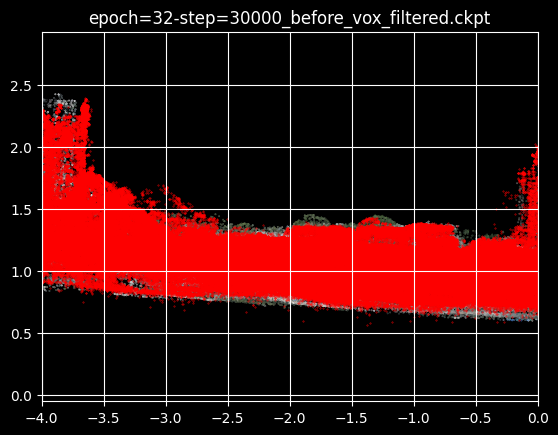

In [12]:
plt.figure()

plt.scatter(data_np_pcd[::100, 0], data_np_pcd[::100, 2], s=0.1, c=data_np[::100, 3:6] / 255.0)
plt.scatter(xyz[mask][::10, 0], xyz[mask][::10, 2], s=0.1, c='r')
# plt.scatter(xyz_coarse[mask][::100, 0], xyz_coarse[mask][::100, 2], s=0.1, c='b')
plt.axis('equal')
plt.xlim(-4, 0)
# plt.ylim(-4, 0)
plt.title(ckpt_path.split('/')[-1])
plt.grid()
plt.show()

In [75]:
model.delete_gaussians(~vox_mask)
checkpoint = torch.load(ckpt_path)
model_params = model.to_parameter_structure()
checkpoint["state_dict"]["gaussian_model._xyz"] = model_params.xyz
checkpoint["state_dict"]["gaussian_model._opacity"] = model_params.opacities
checkpoint["state_dict"]["gaussian_model._features_dc"] = model_params.features_dc
checkpoint["state_dict"]["gaussian_model._features_rest"] = model_params.features_rest
checkpoint["state_dict"]["gaussian_model._scaling"] = model_params.scales
checkpoint["state_dict"]["gaussian_model._rotation"] = model_params.rotations
checkpoint["state_dict"]["gaussian_model._features_extra"] = model_params.real_features_extra

torch.save(checkpoint, ckpt_path.replace('.ckpt', '_vox_filtered.ckpt'))